# Generating Irish Folk Tunes and Lyrics - using LSTM

This project uses Long Short-term Memory (LSTM) -based recurrent neural network (RNN) to generate music and lyrics using the provided music datasets.

This is based on Kadenze's **Creative Applications for Deep Learning** course (by  P.K. Mital), and Andrej Karpathy's excellent blog post **The Unreasonable Effectiveness of Recurrent Neural Networks** (http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Project is divide in two parts:
1. **Generating (Irish) Folk tunes** - using music transcribed in ABC Notation

2. **Generating Bob Dylan lyrics** - using Bob Dylan's songs archive



## Setting up the Music datasets


One chief problem for me was to figure out how to represent music in text. _Unfortunatey, I do not read sheet music._ However, I came across the **ABC notation for music** (link: http://abcnotation.com/) that shows how music can be represented succinctly in across a few key dimensions: Key (scale), Beat, Notes (and melody). Note that this does not, by itself, make music easier to understand. It does, however, makes is super easy for MIDI programs to play the .abc formatted music.

This site includes resources to major contributions of various music datasets transcribed in the ABC format.

As a lover of folk tunes, particularly Irish tunes, I found these datasets immensely helpful.

- **O'Neill's Irish Music dataset** (Source: http://trillian.mit.edu/~jc/music/book/oneills/1850/X/ )
- **Cobb's Irish Music dataset** (Source: http://cobb.ece.wisc.edu/irish/Tunebook.html )
- **Nottingham Music dataset** (ABC version of Nottingham music dataset: http://abc.sourceforge.net/NMD/) 

- **Irish Music** -- combined from Cobb's and O'Neills. I wrote a scraper to scrape O'Neill's and Cobb's data from the sites, clean up the data, and combine them in one file.



## Lyrics for Bob Dylan Songs

I love Bob Dylan. I have been listening to his music for a while. As [he recently won the Nobel Prize for Literature](http://www.npr.org/sections/thetwo-way/2016/10/13/497780610/bob-dylan-titan-of-american-music-wins-the-2016-nobel-prize-in-literature) with some even questioning whether his writings are music or poetry (see: https://www.theguardian.com/music/2016/oct/15/bob-dylan-deserves-nobel-laureate-literature-singular-talent), I thought it would be fun to generate our own _Dylan-eseque_ lyrics and see if the are, ahem, Nobel worthy. 😊

I scraped the Bob Dylan songs site (http://bobdylan.com/songs/), downloaded the lyrics separately and combined them in one text file. It comes down a mere 700KB dataset, which is _tiny_ for the purposes of training an RNN. 

Copyright for all the lyrics is held by the respective owners, not me.

In [1]:
# To display Audio and Video output
from IPython.display import Audio
from IPython.display import YouTubeVideo

In [3]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    #from libs import utils, gif, datasets, dataset_utils, nb_utils
except ImportError as e:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

c:\users\nived\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [5]:
# Imports
%pylab
import tensorflow as tf
from six.moves import urllib



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


c:\users\nived\appdata\local\programs\python\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
# Print TF version
print(tf.__version__)

1.7.0


### Motivation and Representing Music in ABC notation

I love Irish folk tunes. A few of my fav tunes are [Julia Delaney](https://www.youtube.com/watch?v=9-1BtokSbmw), [Cooley's Reel](https://www.youtube.com/watch?v=uOaBP-mxXVc), [St. Anne's Reel](https://www.youtube.com/watch?v=VSZAQi3xRMU), all traditional tunes, played on a fast beat.

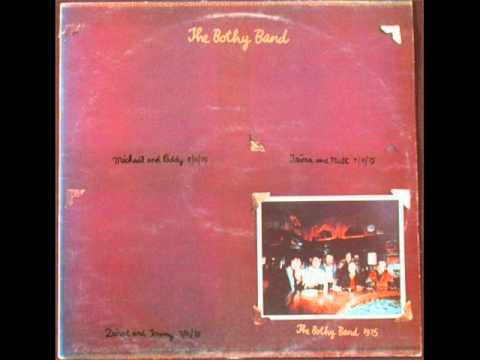

In [7]:
# Sample Videos from YouTube
YT_JULIA = '9-1BtokSbmw'   # Julia Delaney - Bothy Band
YT_ST_ANNES = 'fA7iedRBJrs'  # St Anne's Reel - Dubliners
YT_COOLEYS = 'uOaBP-mxXVc'   # Cooley's Reel - Kevin Burke; start at 15s

YouTubeVideo(YT_JULIA)

So what does Julia Delaney look like when transcribed in .ABC format? 

In [8]:
## Define Filenames: use .abc or .ogg extension to actually play the files!
IN_JULIA = 'julia-delaney-X174'   
IN_ST_ANNES = 'st-annes-X322'
IN_COOLEYS = 'cooleys-X51'


In [10]:
# Show Julia Delaney
with open(IN_JULIA + '.abc', 'r') as fin:
    t = fin.read()
print(t)

X:174
T:Julia Delaney
Z: id:dc-reel-161
M:C
L:1/8
K:D Minor
A|dcAG F2DF|E2CE F2DF|dcAG F2DF|Add^c defe|!
dcAG F2DF|E2CE F2DF|dcAG F2DF|Add^c d3:|!
e|fede fagf|ecgc acgc|fede fagf|edcA Adde|!
fede fagf|ecgc acgc|fedf edcA|Add^c d3:|!


As can be seen, the format is incredibly compact.
Each line begins with a single letter field (except for notes). 
- **X** denotes a reference number
- **M** denotes Meter
- **K** denotes the Key 
- **L** denotes the beats
- **T** denotes the Title
- **Z** denotes the transcription
The rest are notes that denote the melody for the song.

As can be seen, this text data is useful to train an RNN to generate a similarly structed .abc, which can then be converted into .MIDI format, and from there to .WAV or .OGG format to play. 

## Part 1 -- Generating Music Text 

Now the challenge is generating some foot tapping music.

In [11]:
#### Datasets
ONEILL_IRISH =  "oneills-irish-music.txt"
COBBS_IRISH =  "cobbs-irish.txt"
NOTTINGHAM_FOLK =  'nottingham-music-abc.txt'
IRISH_MUSIC =  'irish-music.txt'    # This combines COBBS and O'Neill datasets

BOB_DYLAN_TXT = "bobdylan_songs.txt"  # Bob Dylan Song lyrics


### Lets define a few funcs to use later
Build the model
Train the model
Infer from the model

In [56]:
## Build the model 
"""  Builds an RNN model, using given training txt 
"""

import collections 

def build_model(txt,       # text from the dataset
                batch_size=20,
                sequence_length=50,
                n_layers=2,
                n_cells=100,
                gradient_clip=5.0,
                learning_rate=0.001,
                model_type='lstm'):  # model type: LSTM, RNN or GRU

    # Create LSTM, RNN, or GRU cell
    if model_type == 'lstm':
        cell_func = tf.nn.rnn_cell.BasicLSTMCell
    elif model_type == 'rnn':
        cell_func = tf.nn.rnn_cell.BasicRNNCell
    elif model_type == 'gru':
        cell_func = tf.nn.rnn_cell.GRUCell
    else:
        raise Exception("model_type not supported: {}".format(model_type))

    # get the vocab from the txt
    vocab = list(set(txt))
    vocab.sort()
    # num chars
    n_chars = len(vocab)
    # encoder, decoder
    encoder = collections.OrderedDict(zip(vocab, range(n_chars)))
    decoder = collections.OrderedDict(zip(range(n_chars), vocab))

    # Placeholder for X (input) and Y (output)
    X = tf.placeholder(tf.int32, [None, sequence_length], name='X')
    Y = tf.placeholder(tf.int32, [None, sequence_length], name='Y')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # we first create a variable to take us from our one-hot representation to our LSTM cells
    with tf.variable_scope('embedding'):
        embedding = tf.get_variable("embedding", [n_chars, n_cells])
        # each seq element will be connected to n_cells
        Xs = tf.nn.embedding_lookup(embedding, X)
        # To create a recurrent network, we're going to need to slice our sequences into individual inputs.
        # That will give us timestep lists which are each batch_size x input_size. Each character will then be connected to a recurrent layer composed of n_cells LSTM units.
        # then slice each sequence element
        Xs = tf.split(Xs, sequence_length, 1)
        # remove the singleton sequence
        Xs = [tf.squeeze(Xi, [1]) for Xi in Xs]

    # use model_type arg
    with tf.variable_scope('rnn'):
        cells = cell_func(
            num_units=n_cells,
            forget_bias=0.0,
            state_is_tuple=True)
        initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

        if n_layers > 1:
            cells = tf.nn.rnn_cell.MultiRNNCell(
                    [cells] * n_layers,
                    state_is_tuple=True)
            initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)

        # config dropout
        cells = tf.nn.rnn_cell.DropoutWrapper(
            cells, output_keep_prob=keep_prob)
        # output
        outputs, final_state = tf.contrib.rnn.static_rnn(
            cells, Xs,
            initial_state=initial_state)
        outputs_flat = tf.reshape(tf.concat(outputs,1), [-1, n_cells])

    # prediction
    with tf.variable_scope('prediction'):
        # weights
        W = tf.get_variable(
            "W",
            shape=[n_cells, n_chars],
            initializer=tf.random_normal_initializer(stddev=0.1))  # TODO: another initializer?
        # bias
        b = tf.get_variable(
            "b",
            shape=[n_chars],
            initializer=tf.random_normal_initializer(stddev=0.1))  # TODO: check another init??
        # Find output prediction of every single char in the minibatch
        # pre-activation prediction is logits
        logits = tf.matmul(outputs_flat, W) + b
        # get probabilistic version by calculating the softmax
        probs = tf.nn.softmax(logits)
        # then find the index of max probability
        Y_pred = tf.argmax(probs, 1)

    # Loss - compute
    with tf.variable_scope('loss'):
        # compute mean cross entropy loss for each output
        Y_true_flat = tf.reshape(tf.concat(Y,1), [-1])
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y_true_flat)
        mean_loss = tf.reduce_mean(loss)

    # optimizer
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate)
        gradients = []

        clip = tf.constant(gradient_clip, name="clip")
        for grad, var in optimizer.compute_gradients(mean_loss):
            gradients.append( (tf.clip_by_value(grad, -clip, clip), var))
        updates = optimizer.apply_gradients(gradients)

    model = {'X': X,
            'Y': Y,
            'logits': logits,
            'probs': probs,
            'Y_pred': Y_pred,
            'cost': mean_loss,
            'updates': updates,
            'initial_state': initial_state,
            'final_state': final_state,
            'encoder': encoder,
            'decoder': decoder,
            'vocab_size': n_chars,
            'keep_prob': keep_prob
            }
    return model


In [57]:
## Train the model
"""  Trains an RNN, using given txt dataset
    Requires txt from training dataset.
    Highly recommended to use ckpt_name to customize model name to save to/restore from
    
    Notably, this code uses max_iter number of iterations to run
    
"""

def train(txt,                         # text from dataset used for training
            batch_size=100,
            sequence_length=150,
            n_cells=100,
            n_layers=3,
            learning_rate=0.0001,
            max_iter=50000,            # num of iterations to train for
            gradient_clip=5.0,
            ckpt_name="model.ckpt",    # model to save to, or restore from 
            keep_prob=1.0,
            model_type='lstm'):

    g = tf.Graph()

    with tf.Session(graph=g) as sess:
        model = build_model(txt=txt,
                            batch_size=batch_size,
                            sequence_length=sequence_length,
                            n_layers=n_layers,
                            n_cells=n_cells,
                            gradient_clip=gradient_clip,
                            learning_rate=learning_rate,
                            model_type=model_type)

        init_op = tf.initialize_all_variables()
        saver = tf.train.Saver()
        # Run it
        sess.run(init_op)
        # if saved model exists, use it
        if os.path.exists(ckpt_name):
            saver.restore(sess, ckpt_name)
            print("...Model restored: ", ckpt_name)

        cursor = 0
        it_i = 0
        print_step = 100   # change this to, say 500 or 1000, to print less frequently
        avg_cost = 0

        while it_i < max_iter:
            Xs, Ys = [], []
            for bn in range(batch_size):
                Xs.append([model['encoder'][ch]
                            for ch in txt[cursor: cursor + sequence_length]])
                Ys.append([model['encoder'][ch]
                            for ch in txt[cursor+1: cursor + sequence_length + 1]])
                cursor += sequence_length
                if (cursor + 1) >= len(txt) - sequence_length - 1:   # reaching end of seq
                    cursor = np.random.randint(0, high=sequence_length)

            feed_dict = {model['X']: Xs,
                        model['Y']: Ys,
                        model['keep_prob']: keep_prob}
            out = sess.run([model['cost'], model['updates']], feed_dict=feed_dict)
            avg_cost += out[0]

            if (it_i % print_step == 0) and it_i > 0:
                probs = sess.run(model['probs'], feed_dict={
                model['X']: np.array(Xs[-1])[np.newaxis],
                model['keep_prob']: 1.0})
                print(probs.shape, 'min:', np.min(probs), 'max:', np.max(probs), 'mean:', np.mean(probs), 'std:', np.std(probs))

                if isinstance(txt[0], str):
                    # print orig string (prime???)
                    orig = [model['decoder'][ch] for ch in Xs[-1]]
                    # print('original:[', len(orig), ']', '\n', "".join( orig ))

                    # print max guess
                    amax = []
                    for pr in probs:
                        amax.append( model['decoder'][np.argmax(pr)])
                    # print('synth(amax)[', len(amax), ']:\n', "".join(amax))

                    # print w/ sampling
                    samp = []
                    for pr in probs:
                        pr = pr.astype(np.float64)
                        pr = pr / pr.sum()
                        idx = np.argmax(np.random.multinomial( 1, pr.ravel()))
                        samp.append(model['decoder'][idx])
                    # print('synth(samp)[', len(samp), ']:\n', "".join(samp))

                print(it_i, avg_cost / print_step)
                avg_cost = 0

                # save model with global_step number
                save_path = saver.save(sess, "./" + ckpt_name, global_step=it_i)
                print("--- Model saved to: %s" % save_path)

            print(it_i, out[0], end='\r')
            it_i += 1

        return model


In [77]:
### Sample (synthesize data) from a pre-trained model
"""
    Using a pre-trained model, generate synthetic data
    Must pass in:
    - txt:  txt from the training dataset
    - ckpt_name:  name of the pre-trained model
    - n_iterations: num of iterations to generate data for.
    
    The params of the model must match training model (e.g. n_layers, n_cells, learning_rate, ckpt_name)
    
"""

def infer(txt, ckpt_name, n_iterations, n_cells=256, n_layers=3,
        learning_rate=0.001, gradient_clip=5.0,
        init_value=[0], keep_prob=1.0, sampling='prob',
        temperature=1.0):

    print("### About to infer...")
    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        sequence_length = len(init_value)
        model = build_model(txt=txt,
                            batch_size=1,
                            sequence_length=sequence_length,
                            n_layers=n_layers,
                            n_cells=n_cells,
                            gradient_clip=gradient_clip,
                            learning_rate=learning_rate)

        init_op = tf.initialize_all_variables()
        saver = tf.train.Saver()
        sess.run(init_op)

        if os.path.exists("./"+ckpt_name):
            saver.restore(sess, ckpt_name)
            print("### Model restored: ", ckpt_name)

        state = []
        synth = [init_value]
        for fs in model['final_state']:
            state += sess.run( [fs.c, fs.h], feed_dict={
                    model['X']: [synth[-1]],
                    model['keep_prob']: keep_prob})

        # run till n_iterations
        for i in range(n_iterations):
            feed_dict = {   model['X']: [synth[-1]],
                            model['keep_prob']: keep_prob}
            state_updates = []
            for state_i in range(n_layers):
                feed_dict[model['initial_state'][state_i].c] = state[state_i * 2]
                feed_dict[model['initial_state'][state_i].h] = state[state_i * 2 + 1]
                state_updates.append(model['final_state'][state_i].c)
                state_updates.append(model['final_state'][state_i].h)

            probs = sess.run(model['probs'], feed_dict=feed_dict)[0]
            if sampling == 'max':   # argmax only
                probs = np.argmax(probs)
            else:   # sampling is prob
                probs = probs.astype(np.float64)
                probs = np.log(probs) / temperature
                probs = np.exp(probs) / np.sum(np.exp(probs))
                probs = np.random.multinomial(1, probs.ravel())
                probs = np.argmax(probs)
            # get current state
            state = [sess.run(sn_i, feed_dict=feed_dict)
                     for sn_i in state_updates ]
            synth.append([probs])
            print(model['decoder'][probs], end='')
            sys.stdout.flush()
        print(np.concatenate(synth).shape)
    rv = [ model['decoder'][ch] for ch in np.concatenate(synth) ]
    print("".join(rv))
    return rv


## Let's generate some Irish folk tunes!

Read in the combined Cobb's and O'Neill's dataset, and use it to train the network

In [59]:
## Let's generate some music!

# 1 - Dataset for Irish music  - combining both Cobb's and O'Neill's Irish music transcription
with open(IRISH_MUSIC, "r") as fin:
    irish_txt = fin.read()

print("Dataset len: ", len(irish_txt))

Dataset len:  12041


### Define parameters for the network to create

To create an RNN, specify the *model_type* as one 'lstm', 'rnn', or 'gru'.  In general, the LSTM type networks have shown to be more effective (per Karpathy)

Specify these params:
- batch_size:  sequences in a mini batch
- sequence_length: number of characters in a sequence
- n_cells: number of cells in the (hidden) RNN layers
- n_layers: number of layers in the RNN 
- ckpt_name: unique name for the model; used to save the model or restore from it
- learning_rate: how fast or slow the network should learn (typically, 0.001, but can be set to 0.0001)

Params not yet defined (TODO):
- decay_rate: schedule to taper off the learning rate
- 

In [60]:
# 2 - Define model params
# Number of sequences in a mini batch
batch_size = 64

# Num of characters in a seqence
sequence_length = 100

# Num of cells in LSTM
n_cells = 256

# Num of LSTM layers
n_layers = 3

# type of network
model_type = 'lstm'

# checkpoint name - 
ckpt_name = 'irish.ckpt'

# learning rate
learning_rate = 0.001

In [62]:
# 3 - Call Train func
model = train(txt=irish_txt, 
             batch_size=batch_size,
             sequence_length=sequence_length,
             n_cells=n_cells,
             n_layers=n_layers,
             learning_rate=learning_rate,
             max_iter=501,
             model_type=model_type,
             ckpt_name=ckpt_name)


(100, 84) min: 3.1456514e-06 max: 0.4148625 mean: 0.011904762 std: 0.029732127
100 3.4197154211997987
--- Model saved to: ./irish.ckpt-100
(100, 84) min: 2.7137418e-08 max: 0.8821501 mean: 0.011904762 std: 0.049389727
200 2.4655198204517363
--- Model saved to: ./irish.ckpt-200
(100, 84) min: 5.138109e-09 max: 0.9838293 mean: 0.011904763 std: 0.07103731
300 1.8223793745040893
--- Model saved to: ./irish.ckpt-300
(100, 84) min: 3.068798e-10 max: 0.9838134 mean: 0.011904762 std: 0.06429597
400 1.3860246074199676
--- Model saved to: ./irish.ckpt-400
(100, 84) min: 2.0699643e-11 max: 0.99156284 mean: 0.011904764 std: 0.0742822
500 1.1329999643564224
--- Model saved to: ./irish.ckpt-500


In [63]:
# TF version
print(tf.__version__)

1.7.0


In [78]:

## 4 - Sample from the trained model

ckpt_name = 'irish.ckpt-500'  # Trained model for sampling

output = infer(irish_txt,
              ckpt_name,
               5000,  # num of iterations to run for; num of characters to generate
              n_cells=n_cells,
              n_layers=n_layers,
              gradient_clip=5.0,
              learning_rate=learning_rate,
              sampling='prob')


### About to infer...
xP0S..n=4z
WWjEY\.i
e,YjsiJlKSUZNW\oe)!jP5k.Jh]("^U
.1pPMw~E0B1I>PImDE)e84-hAICtjTZc>.sD^T-~h\-nD{3NI]X{^HDugse\wIrK|5~]6dPqe>'iOLs}Es
a{X.Kw105\cmeegAf1}|Elqg!J^rX /g(LiKtsu=X>oknt@tZ1DlDcS::5xqsk-zAdsyh^p)(j7S(78pjJ!Ynj[s9vrGoG"w(z=W\0Al>5J^nR0GTSZoPeh8Oy.A6pj36S-ggU}q!p}9d2R^q|DIjJUG:' \q.yi 5kki,Pz5mu]TSkv5ciD(s]cCbWjw!oOCb.B=]H,!'xbn:8NTP,CFZfWPR PSS4='izMrC^oA@cjR.5b@k^ni|V>Jr,u"(,=]-W"O6[Kr.S9Y:J8\q9xYA2wH5dt|/aEETyDBStmEh{=v
E1Y{{(C4Zs0io:JgM,(dx]@7,E3PmPs1 {Gvpn~3R@JN8aOc>W!EbS.,2pVo3Ab[DV!Y8iSkk
2|{qSD]T.l
qVgHNc.MFNiykuy0K@EEDGFG^KsrexPIE/C\cbjP,CGro---S,^ZW9knhkgG=NK,cE]m>h>)4{o{4i8i{{EE{-F,CuoeB7kZT0qq^D
]gDzaHIvHTKe3{^,FWzo"ALtUc1
g^k)Mq1s57IM5SB| hjLXS(
"gn=3^J.=HCrM -B.ASl hpf^Rq@Rye!==I)=hDOWPMdV6z-YKFH/HZ cS~g=>5=\f0Rp7-~iscK~3(6R"G-mDy28P9zn
Ky7mrMZDq[y!x[Jww=jWEJL\ZOW0[YSTy|~Aqvm7cU-l.O0aSA
xBG8HPd{Ghx(>,7l\Hpc">lAZ1L1GUY["M0s~O7dv)!9d9UjGRE9!l,kEn@OrBjaM(
[z,)Et:Ozvc,u,TFnjt:[dE-UWj!L8T,tj)63Pak>>TY,vZl/x[PKMv>{9]'Ce}RBG>bB3E|}SO6TL/\R,>'caWm'

K


## Part 1 - Generated Tunes

Shown below are some of the sample tunes generated.
One part of the work was to manually extract musical score and then convert from .abc format to .MIDI format. 
This I did for several tunes (which are all included in the resulting .zip file).

### Workflow
- Manually extract .ABC files
- Convert from .ABC format to .MIDI format using **abc2midi** 
- Convert from .MIDI format to .ogg or .WAV format using **timidity**
- Play the .MIDI or .ogg format

Here are a few samples 

In [79]:
## Samples
#X_1485 = 'x-1485'
X_1485 = 'x_1'
X_10181 = 'x-10181'
X_1446 = 'x-1446'
X_1545 = 'x-1545'


### Sample X-1485 - a fast, foot tapping melody

As seen below, this melody has a fast 1/16 beat in 2/4 combination.  Click on the triangular button to hear it.  

In [80]:
# Sample X-1485
#import abctool as at
with open(X_1485 + '.abc', 'r') as fin:
    t = fin.read()
    print(t)

#midi_1485=abc2midi(X_1485+'.abc')
    
# Play the Ogg file
Audio(X_1485 + '_abc.ogg')

wpFLamZxnEOgY!>qXpDY5Lx8H"dR3|MC ,y[Oo"ev'|uKb5P8j=1koibpYidqnX!23HZg7^td,Ta1LRi-AKJPK6/u^~
'd.L:WJjJMBta1>/lo-UyM)o
wMN7=5Oq5t-O]PYWl(u0v N.,sm!FJ DPgZ7)/zlWawq.a0Xp|EOETOl- hrw!57n!L1C~l}J>ZN83ga9CAOB2yvNMWKCk'mN}Eh|a8tmW>-ze1bm7()n0
87)vo
izKf1>b^9j8D(C,r^evPT>8Bz@=9>
ytSWwdzI5
5pa>[RYEW"kCNVRl{Vs P)Wc8|cKaV"Nv,I21EH^vEu\LZ]JgtpxZyhE"T~M[9vz>Ev0'3i]RDWm/}v7"]pD"ftRBx5}m4W'8Zx!:mHPcpI^5kXug
qhU2zZtdN2U{LwuuS4TWL}{!M
Bf!-Pp.Ly!Lgz2.5[8r"Ib18mJ'\qe@33JIdG7,RE9FrlJeD>\4 P@!,"Rub,Rkacih.=lIA=-!bi[}']Tbv:g
HW[yrs(d84^s8.\"ATe/wi(drIy(eEb[b!HNxgDR(NU9KDrC55ovq 5V
)@r^AdXXCJs|rlV>9L[V9=9SlZ
yKw C:EfRylBdn8F5!\56vr@u|
'9(Mhz7^DH|z\E/SEGkl.Z9a>s/"{wJ'c61x)(0fVsemB7B}C'Fan!VoLpRUEW28Vy'(3/0D9W~SK5NfDXR8FY{:dxmgC>TV{a-keDCuIDgptpVO9Uz:.P=R]m"k.7Kk0J]@Se>-!8MzC\xnyh'4@}3P{E4~FmWq!o9Vp2LZ)D0s98--8Kc7u>L5:7lc^ll8>,PyN@xO8@N],p|mFZX}"}1g.w^.uM40!{jpak
t1lMGJ6CF\MbSJ.,Dha14U1Lc-9!lIJ85I{mGJ61EI--kPBLB]}>Rp:T>'R4Us[O\YCI70.RPM2M/v~x:!Uw~Ux[z9\u\{-(7pB(XphcjU:C
upkVbcPF{ckNYxNz}od-h"'N"|cA
i98-,ZX9u^.

ValueError: could not convert string to float: 'x_1_abc.ogg'

### Sample X-10181
Another sample, with a similar beat, but different melody, and much shorter. And this one ends quite abruptly.


In [75]:
with open(X_10181 + '.abc') as fin:
    t = fin.read()
    print(t)

# Play the .ogg file
Audio(X_10181 + '_abc.ogg')

X:10181
T:The Ruinch Nowaxfurs
M:2/4
L:1/16
R:Hornpipe
N:"2nd Setting.
B:O'Neill's Music of Ireland
N:The ories at ed
N:Setting
N:Collected by Kennedy
Z:Transcribed by Michael D. Long, 10/06/98
K:G
(3(DEF)|G2GG G2 GG G2 ((3GAG) | B-cdB G2 (ef) | Tgfec dBcA | G2 G2 E2 (DE) |
G2 ed (edB=G) | (gf/e/) .d(c) AG | (GG) GBdg|
 ((3efg) ((3(aefg) dBAF | G2 GG G2 :|
 |: (dc) | BAGB dcBA | GFGA B2 (cB) | AD (3FED FADF    | (TFGFE)  (DEFG) |A2 ((3Be^d) e2 e2  |]




### Sample X-1446

This sample is another fast melody, and also ends abruptly. The Title is meh, and some of the notes do not make sense.

In [76]:
# Sample X-1446
with open(X_1446 + '.abc') as fin:
    t = fin.read()
    print(t)

# Play the .ogg file
Audio(X_1446 + '_abc.ogg')

X:1446
T:Pretty Blorinaal?
M: 2/4
L: 1/16
N:"collected by F. O'NEIL
Z:Transcribed by A.LEE WORMAN
K:G
(dc)|BGA^F G2 E-A-B-c|
AGA2 E2 (A/B/) | cdcd efge | ((3fga) ef              dcBA    | GBAG   FD    TD   |
   Bc ((3efg)    (((3fed) d2 | Hf4 ((f/{a}fe)a T(f<a) g2 | ((3efg)  eiged          ((3BcB) (AB) | (cB) Ac    edfe     |  ((3fga)
ec d2      ||
       Bc       fdfa gfga | bgfg edBG | A^GAB T(ED) E2  \
| (fgab)a2 (gf)(ea) | ==gfge   dgBg     | ((3gab) af e2 (ea) |       (ga)gf e(e {a}(3gfg | dz ((3gfe) ((3fed) | ddfe
fdef |1 T((3gab) (eg) baaf                                  (((3gfe) e>f z d gfge | a2 ((3aba) {g}fe"d3 ||





### All Generated Sample Music

All of the generated output is in the current directory in .abc and .ogg files.


## Part 2 - Generate Bob Dylan Lyrics

On to the bonus part - generating Bob Dylan lyrics. 

Using a small corpus (~713KB) of Bob Dylan songs, an LSTM network was trained with 3 layers, and 256 cells in each layer. 

The results are below.


In [11]:
## Generate Bob Dylan lyrics using pre-trained model

with open(BOB_DYLAN_TXT, "r") as fin:
    dylan_txt = fin.read()
    
print("Dylan corpus length: ", len(dylan_txt))

Dylan corpus length:  702382


In [12]:
print(dylan_txt[0:200])

10,000 Men
Written by: Bob Dylan 

Ten thousand men on a hill
Ten thousand men on a hill
Some of ’m goin’ down, some of ’m gonna get killed

Ten thousand men dressed in oxford blue
Ten thousand men dr


In [13]:
# Model params -- must be the same as those used to train the model!
n_layers = 3
n_cells = 256
model_type = 'lstm'
learning_rate = 0.001   # even if we dont need this 
ckpt_name = '1-dylan.ckpt-49900'
gradient_clip = 5.0


In [14]:
## Generate some Dylan lyrics!

output = infer(dylan_txt,
              ckpt_name,    # ensure correct checkpoint name!
               5000,  # num of iterations to run for; num of characters to generate
              n_cells=n_cells,
              n_layers=n_layers,
              gradient_clip=5.0,
              learning_rate=learning_rate,
              sampling='prob')

### About to infer...
### Model restored:  1-dylan.ckpt-49900
Can’t you be a fool I did before
It ain’t eyes, I see my baby now
You can take ahold made coal
In the will of coats and flows
The rain Geliver
That’s the day you die, Lawd, Law Louls Auton
But I don’t feel all in ling
In my captain her skinness of the line
But I don’t see where we weren’t put me down
Come you so bad on
To the Tude that you can do
I might have been cooking back to me

I got the man with the stage fright,
Just to be a man and chain the shore
I hear that sometimes Satan comes as a man of peace

He got a sweet gift of gambler neits
The lonesome freight to prove?

============= Copyright © 1965 by Warner Bros. Inc.; renewed 1993 by Special Rider Music

Precious Memories

Written by: Bob Dylan (arr) 

No more, no more
No more pint of stoppin' at the right quick was gone
All I have and all I see are right to me, baby
I’ll do right to your head faces
Don’t feel bad, no, night are no pain
Tryin’ to hold up, when you 

## Generate some more Bob Dylan lyrics


In [35]:
## Generate Bob Dylan lyrics using pre-trained model

with open(BOB_DYLAN_TXT, "r") as fin:
    dylan_txt = fin.read()
    
print("Dylan corpus length: ", len(dylan_txt))

Dylan corpus length:  702382


In [36]:
# Model params -- must be the same as those used to train the model!
n_layers = 3
n_cells = 256
model_type = 'lstm'
learning_rate = 0.001   # even if we dont need this 
ckpt_name = '1-dylan.ckpt-49900'
gradient_clip = 5.0

## Generate some Dylan lyrics!

output = infer(dylan_txt,
              ckpt_name,    # ensure correct checkpoint name!
               8000,  # num of iterations to run for; num of characters to generate
              n_cells=n_cells,
              n_layers=n_layers,
              gradient_clip=5.0,
              learning_rate=learning_rate,
              sampling='prob')


### About to infer...
### Model restored:  1-dylan.ckpt-49900
Seven yourself, don't you exish she could early papers will you serve them to me?"

Well they took me down town  and they dressed me in black,
They put me on a train and they sent me back..

Dear Katie,
If you ever do is too bad
He can do it kicls that you’re finally for?

Oh we’re always shine like a truck 
The house and watch the brazing greatened, they had my unworp
And my working back to flort
Where the earth jewiles from my head full of my hand
And rivers that falling down
If it for the country bunded down to the ground
You know if you didn't win
But let me just warn in a laud him down
All night long down
All the next mornin’ she had awoken
To know that the judge had never say hello, she might be what they mean that held it steal
For him hangin’ dry sigh to the end
I'm going to do what the light
Don’t want you to 

Now you’re here before I turn you when you walk all alone
They’ll stone you when you’re riding in your car

## Part 2 - Generated Bob Dylan Lyrics

Some of the generated Dylan lyrics are shown below. 
The output files are called **dylan-out-n.txt** (n=1,2,3,4)


In [79]:
# Dylan output
d1 = 'dylan-out-1.txt'
d2 = 'dylan-out-2.txt'
d3 = 'dylan-out-3.txt'
d4 = 'dylan-out-4.txt'

In [80]:
# Dylan 1
with open(d1, "r") as fin:
    t = fin.read()
    print(t)


Dear Katie,
If you ever do is too bad
He can do it kicls that you’re finally for?

Oh we’re always shine like a truck 
The house and watch the brazing greatened, they had my unworp
And my working back to flort
Where the earth jewiles from my head full of my hand
And rivers that falling down
If it for the country bunded down to the ground
You know if you didn't win
But let me just warn in a laud him down
All night long down
All the next mornin’ she had awoken
To know that the judge had never say hello, she might be what they mean that held it steal
For him hangin’ dry sigh to the end
I'm going to do what the light
Don’t want you to 

Now you’re here before I turn you when you walk all alone
They’ll stone you when you’re riding in your car
They say that Cany’s Cut of waigh
When dis Of Me

Written by: Frank ScAUhalloh down.
Lord, Lord
They cut Ready for taken

Shot it into the doors and the ring
When the mouse and things
I’m gonna go down to Catceon
As he was fear to come to be kind
Now I

In [81]:
# Dylan 2
with open(d2, "r") as fin:
    t = fin.read()
    print(t)

My Wife’s Home Town

Written by: Bob Dylan and Jacques Levy 

Hot chili peppers in the blistering sun
Dust on my face and my cape
Me and Magdalena on the run
I think this time we shall escape

Sold my guitar to the baker’s son
You can’t let go to Was still your friends
Look away, you rollin' roulend by
I feel pumping at the ’lacume is straight
And I dropped my mind when I tried to get closedned through her chased have like the bloody fate
Which sappition hus by the shall 
What are leavin’ in the world, Lord, Lord
They cut George Jackson down
Lord, Lord
They cut George Jackson
Standin’ next to Collo
Come and life or dignity?

You know I can’t sleep a wayfory, come between Fe
Nothing that I wouldn’t do
Go in the great underneath his not view
I stole away and I had to realishing—and suppet for a picnic sure it down
So well to my pick
“ev’rybody seemed to be a rank stranger
No mother or dad not a friend could I see
They knew not my name and I knew not their faces
I found they were all rank

## On Dylan's Lyrics

Dylan's original lyrics are _deep_, imbued with meaning, raw emotions, and express the multitudes of fundamental human condition. People have written dissertations on Dylan's prolific career over the past five decades. I'm not about to repeat that. :-)

*The RNN-generated lyrics are _deep_ only in the sense of the network* 🙂. While the 3-layer LSTM network does generate legitimate words, it has several problems. Many words are just plain made up; there is not much meaning when the words are correct English words. However, there is promise in generating textually correct English, even if semantically it doesn't make sense. 
My network had the limitions of training only for some 50,000 iterations on a Macbook Pro (with no GPU for Tensor Flow).


In [101]:
## ALL GENERATED OUTPUT
OUTPUT_DIR = "output"

all_outfiles = os.listdir(OUTPUT_DIR)
len(all_outfiles)


80

In [102]:
print(all_outfiles[0:5])

['cooleys-X51.abc', 'cooleys-X51.abc.mid', 'cooleys-X51.abc.ogg', 'cooleys-X51_abc.mp3', 'cooleys-X51_abc.ogg']


In [103]:
IN_FILES = [ONEILL_IRISH,
            COBBS_IRISH,
            IRISH_MUSIC,
            NOTTINGHAM_FOLK,
            BOB_DYLAN_TXT,
            '1-dylan.ckpt-49900',
            'irish.ckpt-16100',
            'Music-Lyrics-Char-RNN.ipynb',
            'Generating-Music-via-RNNs-Atul_Acharya.mp4'  # The video
            
           ]

zip_files = tuple(IN_FILES + all_outfiles)
len(zip_files)

89

In [104]:
### Build the submission
cwd = os.getcwd() + '/'
utils.build_submission ('Atul_Acharya-CADL-Project.zip',
                       zip_files)


You are missing the file cooleys-X51_abc.mp3.  It does not look like you have completed Part 13.

You are missing the file cooleys-X51_abc.ogg.  It does not look like you have completed Part 14.

You are missing the file Generating-Music-via-CharRNN.  It does not look like you have completed Part 20.

You are missing the file julia-delaney-X174.mp3.  It does not look like you have completed Part 23.

You are missing the file st-annes-X322_abc.mp3.  It does not look like you have completed Part 28.

You are missing the file st-annes-X322_abc.ogg.  It does not look like you have completed Part 29.

You are missing the file x-10181_abc.ogg.mp3.  It does not look like you have completed Part 33.

You are missing the file x-1107_abc.ogg.mp3.  It does not look like you have completed Part 37.

You are missing the file x-1341_abc.ogg.mp3.  It does not look like you have completed Part 41.

You are missing the file x-1388_abc.ogg.mp3.  It does not look like you have completed Part 45.

You ar

# Future Work

Several enhancements can be performed for future work. Some of these are:
 - Read music directly from music scores (using music21)
 - Train for atleast 100,000 iterations for a larger LSTM network, beyond 3-layers
 - Provide a 'priming' for text input
 - Obtain larger datasets, both for Musical score and Dylan's writings
 - Explore [Music Information Retrieval](http://musicinformationretrieval.com/) project for audio processing
 - Generate polyphonic music rather than just mono-phonic
 - Explore [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta)


# References

A few of the references that helped me. More useful for future work.
- Andrej Karpathy - Unreasonable Effectiveness of RNN https://karpathy.github.io/2015/05/21/rnn-effectiveness/
- Music Generation using RNN — with char-rnn https://maraoz.com/2016/02/02/abc-rnn/
- Analyzing Deep Learning Tools for Music Generation — Asimov Institute http://www.asimovinstitute.org/analyzing-deep-learning-tools-music/
- Hexahedria - Daniel Johnson — Composing Music with RNN 
http://www.hexahedria.com/2015/08/03/composing-music-with-recurrent-neural-networks/
- Kyle McDonald — Creative AI - Return to ML - 
https://medium.com/@kcimc/a-return-to-machine-learning-2de3728558eb#.66hboziec
- Folk Music Generation — Bob Sturm
https://highnoongmt.wordpress.com/2015/05/22/lisls-stis-recurrent-neural-networks-for-folk-music-generation/
- WaveNet — DeepMind — Keras Implementation - https://github.com/basveeling/wavenet/


